In [12]:
import string
import os
import joblib
import numpy as np
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
from nltk.data import LazyLoader
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils.corpusutils import CorpusPreProcess, Document, Corpus
from utils.featureutils import FeatureProcessor, find_closest

# Define the return_self function
def return_self(x):
    return x

current_directory = os.getcwd()
root = os.path.join(current_directory, "Minutes")
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = LazyLoader("tokenizers/punkt/english.pickle")
category_pattern = r'(\d{4})/*'
file_extension = r'*.txt'
file_pattern = r'(\d{8})/*'
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') + list(string.punctuation) + ['u', '.', 's', '--', '-', '."', ',"', '.)', ')-', '".', '—', '),']

fed_mins = CorpusPreProcess(root=root, file_extension=file_extension,
                            category_pattern=category_pattern,
                            file_pattern=file_pattern,
                            word_tokenizer=word_tokenizer,
                            sent_tokenizer=sent_tokenizer,
                            stemmer=stemmer,
                            lemmatizer=lemmatizer,
                            stop_words=stop_words
                            )

# Load the LDA model and the vectorizer
try:
    lda_model = joblib.load('lda_model_6_topics.pkl')
    vectorizer = joblib.load('count_vectorizer.pkl')
    print("LDA model and vectorizer loaded successfully.")
except Exception as e:
    print(f"Error loading LDA model or vectorizer: {e}")

# Renaming topics
topic_dict = {
    0: "Quarterly Economic Performance",
    1: "Committee Deliberations and Policies",
    2: "Inflation and Prices",
    3: "Economic Growth and Business Activity",
    4: "Credit Markets and Financial Conditions",
    5: "Economic Forecasts and Projections"
}

print("Renamed topics:")
for key, value in topic_dict.items():
    print(f"Topic {key}: {value}")


LDA model and vectorizer loaded successfully.
Renamed topics:
Topic 0: Quarterly Economic Performance
Topic 1: Committee Deliberations and Policies
Topic 2: Inflation and Prices
Topic 3: Economic Growth and Business Activity
Topic 4: Credit Markets and Financial Conditions
Topic 5: Economic Forecasts and Projections


In [18]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_model,vectorizer)


TypeError: prepare() missing 1 required positional argument: 'vectorizer'

In [16]:
pyLDAvis.save_html(lda_model, lda.html)

NameError: name 'pyLDAvis' is not defined

In [13]:
#Load tokenizer and model
transformer_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
transformer_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",output_hidden_states=True,output_attentions=False)
 

/Users/chandrajason/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<Axes: title={'center': 'Average net-tone per topic for file:20211215'}, xlabel='month'>

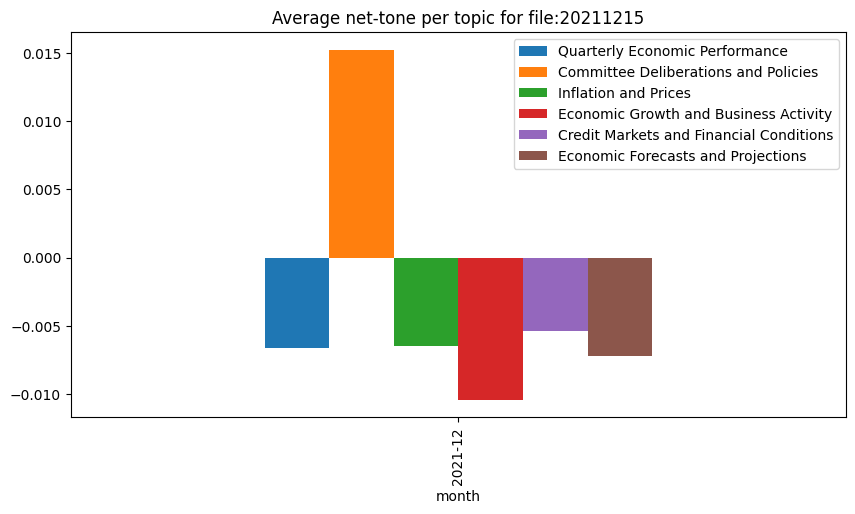

In [14]:
file_id = '20211215'
latest_minutes = fed_mins.get_paras(file_id = file_id,flatten=True,stem=True)
tokenizer_settings = dict(is_split_into_words=True,max_length=350,padding='max_length',truncation=True,return_tensors="pt")

document_feat = FeatureProcessor(latest_minutes,
                                transformer_model=transformer_model,
                                transformer_tokenizer=transformer_tokenizer,
                                tokenizer_settings=tokenizer_settings,
                                lda_model=lda_model,
                                lda_vec=vectorizer,
                                lda_topic_dict=topic_dict,batch_size=30)

latest_minutes = document_feat.get_features(sentiment=True,embedding=True,topic=True)

def corpus_stats(corpus):
    ids = [(n,f.category_id,f.file_id) for n,f in enumerate(corpus)]
    df_ids = pd.DataFrame(ids,columns=['idx','category_id','file_id'])
    start_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='first')
    end_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='last')

    idx = start_idx.merge(end_idx,on=['category_id','file_id'],suffixes=('_start','_end'))

    stats =[]
    corpus_sent = corpus.extract_features('sentiment')
    corpus_topic = corpus.extract_features('topics')

    for s,cat_id,file_id,e in idx.values:
        net_tone = [s['logits'][0] - s['logits'][1] for s in corpus_sent[s:e]]
        topic_dist = [s['topic_dist'] for s in corpus_topic[s:e]]
        topic_sentiment = np.asarray(topic_dist) * np.asarray(net_tone).reshape(-1,1)
        topic_mean_sent = topic_sentiment.mean(axis=0).tolist()

        stats.append((cat_id,file_id,*topic_mean_sent))
    return stats


latest_stats = corpus_stats(latest_minutes)
latest_stats = pd.DataFrame(latest_stats,columns = ['category_id','file_id']+list(topic_dict.values()))
latest_stats['month'] = pd.to_datetime(latest_stats['file_id']).dt.to_period('M')
latest_stats.set_index(['month'],inplace=True)

latest_stats.plot(kind='bar',title='Average net-tone per topic for file:{}'.format(file_id),figsize=(10,5))